# Predicting Authors
## A Natural Language Analysis Project


**Group Members:**

* Kali Blevins (Team Lead)
* Anais Dotis-Georgiou (Tester)
* Danny Lu (Data Engineer)
* Bharathy Natarajan (Scrum Master)

**Summary**

Using the raw datasets from the Kaggle data competition 'Spooky Author', we perform a basic natural language analysis with the aim of identifying particular authors based on a sample of their writing.

## Organize environment

In [1]:
# read in some helpful libraries
import nltk # the natural langauage toolkit, open-source NLP
import pandas as pd # dataframes
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from collections import Counter
from scipy import stats
import string

# initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

### Read in training data
This data will be used to develop an identification algorithm

In [2]:
### Read our train data into a dataframe
texts = pd.read_csv("equal_length_train.csv", encoding = 'latin-1')

# look at the first few rows of texts
texts.head()

,id,text,author
0,id04707,I thrust my arms wildly above and around me in...,EAP
1,id24926,It is noticeable that the popular prejudices a...,EAP
2,id23970,"Could distinguish some words of the former, wh...",EAP
3,id06073,"""I see you are a pupil after my own heart.",EAP
4,id14349,"He said little, and that moodily, and with evi...",EAP


## Initial data organization
* Group data by author
* Create object with all sentences for each author
* Create object with all token for each author

In [3]:
# split the data by author
byAuthor = texts.groupby("author")

# create empty dictionary to store combined sentences for each author
sentence_dict = {}

# create empty dictionary to store tokenized sentences for each author
token_dict = {}

# for each author...
for name, group in byAuthor:
    # get all of the sentences they wrote and collapse them into a
    # single long string
    sentences = group['text'].str.cat(sep = ' ')
    
    # convert everything to lower case (so "The" and "the" get counted as 
    # the same word rather than two different words)
    sentences = sentences.lower()
    
    sentence_dict[name] = (sentences)
    
    # split the text into individual tokens (words)  
    tokens = nltk.tokenize.word_tokenize(sentences)
    
    token_dict[name] = (tokens)


## Basic word & sentence structure analysis
* Average sentence length for each author
* Average word length for each author
* Total word variety for each author

### Get Avg sentence length by author

In [4]:
# make a copy of texts to work with
texts_len = texts.copy()

# add the sentence length for each row
texts_len['sentence_len'] = [len(str.split(s)) for s in texts['text']]

# create column to populate with the unique words used in each sentence
texts_len['vocab'] = [len(set(str.split(s))) for s in texts_len['text']]

texts_len.head()

,id,text,author,sentence_len,vocab
0,id04707,I thrust my arms wildly above and around me in...,EAP,12,12
1,id24926,It is noticeable that the popular prejudices a...,EAP,32,28
2,id23970,"Could distinguish some words of the former, wh...",EAP,13,12
3,id06073,"""I see you are a pupil after my own heart.",EAP,10,10
4,id14349,"He said little, and that moodily, and with evi...",EAP,10,9


In [5]:
# get summary data for each author on the sentence length
sentence_summary = pd.DataFrame(texts_len.groupby('author')['sentence_len'].describe())
sentence_summary

,count,mean,std,min,25%,50%,75%,max
author,,,,,,,,
EAP,5635.0,25.499734,18.573348,2.0,12.0,21.0,34.0,256.0
HPL,5635.0,27.799823,14.123336,4.0,18.0,26.0,35.0,147.0
MWS,5635.0,27.466548,23.558070,2.0,15.0,23.0,34.0,861.0


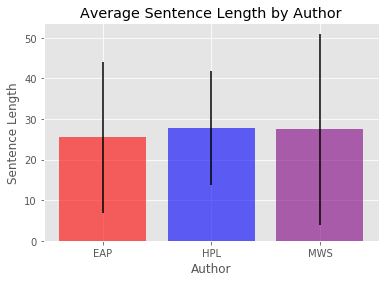

In [6]:
# plot
plt.bar(np.arange(3), sentence_summary['mean'], yerr=sentence_summary['std'], color = ['red', 'blue', 'purple'], alpha = 0.6)
plt.xticks(np.arange(3), sentence_summary.index)
plt.title("Average Sentence Length by Author")
plt.xlabel("Author")
plt.ylabel("Sentence Length")
plt.savefig('plots/avg_sentence_length.png', dpi = 300)
plt.show()


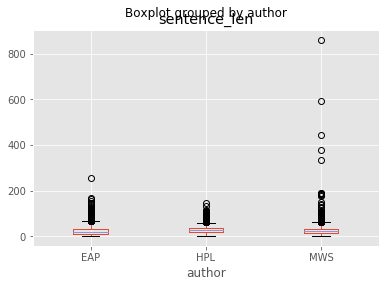

In [7]:
texts_len.boxplot(column = 'sentence_len', by = 'author')
plt.show()

### Get Avg word length by author

In [8]:
# create empty dictionary to populate with average word length by author 
wordlengthByAuthor = {}

# for each author...
for key, value in token_dict.items():
    
    # characterizing words by different lengths
    small_words = len([w for w in value if len(w) <= 5])
    med_words = len([w for w in value if len(w) > 5 & len(w) <10])
    large_words = len([w for w in value if len(w) > 9 & len(w) <15])
    xlarge_words = len([w for w in value if len(w) > 14 & len(w) <15])
    # Average Word Length for each author
    avg_word_length = np.mean([len(w) for w in value])
    # Std Dev of word length for each author
    std_word_length = np.std([len(w) for w in value])
    
    wordlengthByAuthor[key] = ([small_words, med_words, large_words, xlarge_words,avg_word_length, std_word_length])
    
wordlength_df = pd.DataFrame(wordlengthByAuthor, index = ['small (<5)', 'med (5-9)', 'large (10-14)', 
                                                          'xlarge (14+)', 'avg length', 'std'])   
wordlength_df

,EAP,HPL,MWS
small (<5),124846.000000,128090.000000,132658.000000
med (5-9),101844.000000,106770.000000,107901.000000
large (10-14),127360.000000,138675.000000,136918.000000
xlarge (14+),89393.000000,95862.000000,97048.000000
avg length,4.029386,4.182270,4.018869
std,2.623731,2.499797,2.504007


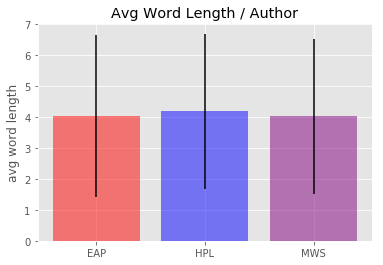

In [9]:
# slicing the 'avg length' row from the avg_len_df
avg_len_df = wordlength_df.iloc[4,:]
avg_len_df = pd.DataFrame(avg_len_df)

# slicing the 'std' row from the std_wordlength_df
std_df = wordlength_df.iloc[5,:]
std_df = pd.DataFrame(std_df)

# creating the plots
y_axis = avg_len_df['avg length']
x_axis = np.arange(0,len(y_axis),1)

# setting tick positions and labels
plt.xticks(x_axis,["EAP","HPL","MWS"])
colors=['red','blue','purple']

plot = plt.bar(x_axis,y_axis,yerr=std_df['std'],color=colors,align='center',alpha=0.5)
plt.title("Avg Word Length / Author")
plt.ylabel("avg word length")

plt.savefig('plots/avg_word_length.png', dpi = 300)
plt.show()

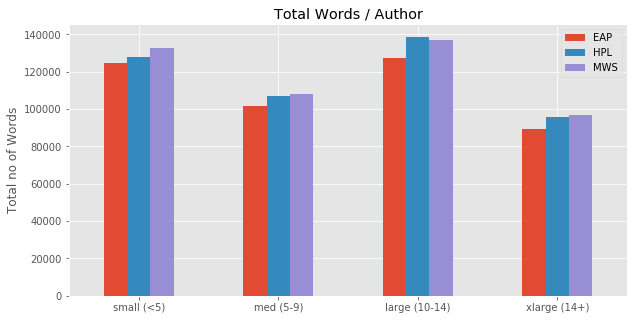

In [10]:
# plotting the words by category for each author with std error bars
wordlength_df2 = wordlength_df.iloc[0:4,:]
wordlength_df2.plot(kind='bar',title = 'Total Words / Author',
                    legend=True, rot=0, figsize=(10, 5))
plt.ylabel('Total no of Words')
plt.savefig('plots/total_words_by_size.png', dpi = 300)
plt.show()

### Get total word variety by author

In [11]:
# create empty dictionary to store the number of unique words used by each author
vocabulary = {}

# for each author
for key, value in token_dict.items():
    unique_words = set(value)
    len_unique_words = len(unique_words)
    vocabulary[key] = (len_unique_words)
    
vocabulary

{'EAP': 13287, 'HPL': 14553, 'MWS': 11294}

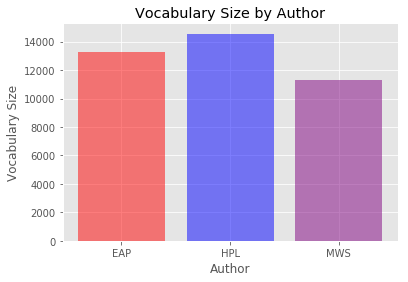

In [12]:
# plot
plt.bar(np.arange(3), vocabulary.values(), color = ['red', 'blue', 'purple'], alpha = 0.5)
plt.xticks(np.arange(3), vocabulary.keys())
plt.title("Vocabulary Size by Author")
plt.xlabel("Author")
plt.ylabel("Vocabulary Size")
plt.savefig('plots/vocabulary_size.png', dpi = 300)
plt.show()

## Part of speech analysis

### Pronoun usage

In [13]:
# Get parts-of-speech for each author using 

firstPerson = ['i', 'me', 'we', 'us']
secondPerson = ['you'] 
thirdPerson = ['he', 'she', 'it', 'him', 'her', 'it', 'they', 'them']
firstCount = {}
secondCount = {}
thirdCount = {}

for key in token_dict:
    counts = Counter(token_dict[key])
    firstCount[key] = { pronoun: counts[pronoun] for pronoun in firstPerson }
    secondCount[key] = { pronoun: counts[pronoun] for pronoun in secondPerson } 
    thirdCount[key] = { pronoun: counts[pronoun] for pronoun in thirdPerson } 

In [14]:
# unpack dictionaries into DataFrames 
authors = ['EAP', 'HPL', 'MWS']
first = []
second = []
third = []

# df for first person pronouns
for name in authors:
    temp = []
    pronoun = []
    values = []
    for key, value in firstCount[name].items():
        temp = [key,value]
        pronoun.append(temp[0])
        values.append(temp[1])
    df1 = pd.DataFrame({'Pronoun': pronoun,
                 name: values,
                }).set_index('Pronoun')
    first.append(df1)
first = pd.concat(first, axis=1)

# df for second person pronouns
for name in authors:
    temp = []
    pronoun = []
    values = []
    for key, value in secondCount[name].items():
        temp = [key,value]
        pronoun.append(temp[0])
        values.append(temp[1])
    df1 = pd.DataFrame({'Pronoun': pronoun,
                 name: values,
                }).set_index('Pronoun')
    second.append(df1)
second = pd.concat(second, axis=1)

# df for third person pronouns
for name in authors:
    temp = []
    pronoun = []
    values = []
    for key, value in thirdCount[name].items():
        temp = [key,value]
        pronoun.append(temp[0])
        values.append(temp[1])
    df1 = pd.DataFrame({'Pronoun': pronoun,
                 name: values,
                }).set_index('Pronoun')
    third.append(df1)
third = pd.concat(third, axis=1)

third

,EAP,HPL,MWS
Pronoun,,,
he,904,1647,1381
she,212,65,854
it,1664,1402,1084
him,287,459,615
her,400,99,1557
they,242,648,459
them,170,288,305


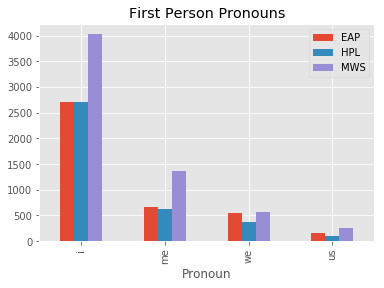

In [15]:
# Plot pronoun DataFrames
first.plot(kind ='bar')
plt.title('First Person Pronouns')
plt.savefig('plots/first_person.png', dpi = 300)
plt.show()

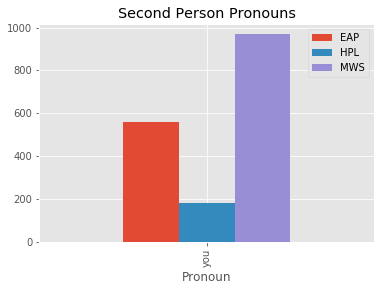

In [16]:
second.plot(kind ='bar')
plt.title('Second Person Pronouns')
plt.savefig('plots/second_person.png', dpi = 300)
plt.show()

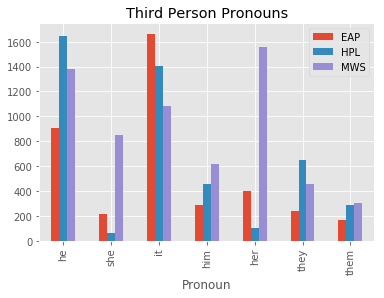

In [17]:
third.plot(kind = 'bar')
plt.title('Third Person Pronouns')
plt.savefig('plots/third_person.png', dpi = 300)
plt.show()

### Other parts of speech

In [18]:
# Get parts-of-speech for each author using 
partOfSpeech = {}

for key, value in token_dict.items():
    
    partOfSpeech[key] = nltk.pos_tag(value)

partOfSpeech

{'EAP': [('i', 'NN'),
  ('thrust', 'VBP'),
  ('my', 'PRP$'),
  ('arms', 'NNS'),
  ('wildly', 'RB'),
  ('above', 'IN'),
  ('and', 'CC'),
  ('around', 'IN'),
  ('me', 'PRP'),
  ('in', 'IN'),
  ('all', 'DT'),
  ('directions', 'NNS'),
  ('.', '.'),
  ('it', 'PRP'),
  ('is', 'VBZ'),
  ('noticeable', 'JJ'),
  ('that', 'IN'),
  ('the', 'DT'),
  ('popular', 'JJ'),
  ('prejudices', 'NNS'),
  ('and', 'CC'),
  ('vulgar', 'JJ'),
  ('errors', 'NNS'),
  ('in', 'IN'),
  ('regard', 'NN'),
  ('to', 'TO'),
  ('pestilences', 'NNS'),
  ('and', 'CC'),
  ('wars', 'NNS'),
  ('errors', 'NNS'),
  ('which', 'WDT'),
  ('were', 'VBD'),
  ('wont', 'NNS'),
  ('to', 'TO'),
  ('prevail', 'VB'),
  ('upon', 'IN'),
  ('every', 'DT'),
  ('appearance', 'NN'),
  ('of', 'IN'),
  ('a', 'DT'),
  ('comet', 'NN'),
  ('were', 'VBD'),
  ('now', 'RB'),
  ('altogether', 'RB'),
  ('unknown', 'JJ'),
  ('.', '.'),
  ('could', 'MD'),
  ('distinguish', 'VB'),
  ('some', 'DT'),
  ('words', 'NNS'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('for

In [19]:
# Count the the number of parts of speech for each author 

# create an empty dictonary to hold all of the counts
partOfSpeechCounts = {}
for name in partOfSpeech: 
     partOfSpeechCounts[name] = Counter(elem[1] for elem in partOfSpeech[name])
        
partOfSpeechCounts

{'EAP': Counter({"''": 1124,
          ',': 12509,
          '.': 5821,
          ':': 1151,
          'CC': 5677,
          'CD': 1026,
          'DT': 18254,
          'EX': 364,
          'FW': 176,
          'IN': 21146,
          'JJ': 11481,
          'JJR': 405,
          'JJS': 350,
          'MD': 1775,
          'NN': 28257,
          'NNP': 94,
          'NNPS': 2,
          'NNS': 5831,
          'PDT': 164,
          'POS': 315,
          'PRP': 5880,
          'PRP$': 3571,
          'RB': 9146,
          'RBR': 282,
          'RBS': 174,
          'RP': 455,
          'TO': 3408,
          'UH': 58,
          'VB': 4719,
          'VBD': 7470,
          'VBG': 2284,
          'VBN': 4555,
          'VBP': 1989,
          'VBZ': 2251,
          'WDT': 1245,
          'WP': 594,
          'WP$': 66,
          'WRB': 573,
          '``': 1116}),
 'HPL': Counter({'$': 1,
          "''": 567,
          ',': 8581,
          '.': 5877,
          ':': 1191,
          'CC': 7793,

### Punctuation

In [20]:
# visualise the above in a dataframe
speech_parts_df = pd.DataFrame(partOfSpeechCounts)
speech_parts_df
speech_parts_df.index

Index(['$', '''', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ',
       'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP',
       'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN',
       'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'],
      dtype='object')

In [21]:
# from the string library, pull the list of punctuations
punctuation = set(string.punctuation)
# Add in the missing punctuations 
punctuation.add('``')
punctuation.add('\'\'')
punctuation

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 "''",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '``',
 '{',
 '|',
 '}',
 '~'}

In [22]:
# iterate through the rows of speech_parts_df and drop the rows if the index is not punctuation mark
for index,row in speech_parts_df.iterrows():
    if(index not in punctuation):
        speech_parts_df = speech_parts_df.drop(index)
        
speech_parts_df

,EAP,HPL,MWS
$,NaN,1.0,NaN
'',1124.0,567.0,643.0
",",12509.0,8581.0,11237.0
.,5821.0,5877.0,5715.0
:,1151.0,1191.0,2797.0
``,1116.0,297.0,767.0


In [23]:
# remove $ since it's only used once
speech_parts_df = speech_parts_df.iloc[1:6,:]
speech_parts_df

,EAP,HPL,MWS
'',1124.0,567.0,643.0
",",12509.0,8581.0,11237.0
.,5821.0,5877.0,5715.0
:,1151.0,1191.0,2797.0
``,1116.0,297.0,767.0


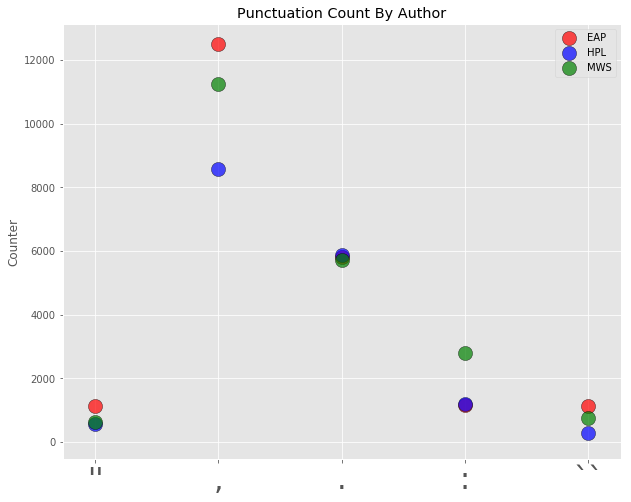

In [24]:
# scatter plot for count of punctuation types by author
xticks = ["''",',','.',':','``']
x_axis = np.arange(0,len(speech_parts_df),1)

y_EAP_axis = speech_parts_df['EAP']
y_HPL_axis = speech_parts_df["HPL"]
y_MWS_axis = speech_parts_df["MWS"]

plt.figure(figsize=(10,8))

EAP_handle = plt.scatter(x=x_axis,y=y_EAP_axis,marker='o',color='r',edgecolors='black',s=200,alpha=0.7,label="EAP") 
HPL_handle = plt.scatter(x=x_axis,y=y_HPL_axis,marker='o',color='b',edgecolors='black',s=200,alpha=0.7,label="HPL") 
MWS_handle = plt.scatter(x=x_axis,y=y_MWS_axis,marker='o',color='g',edgecolors='black',s=200,alpha=0.7,label="MWS") 

plt.legend(handles=[EAP_handle,HPL_handle,MWS_handle],loc='best')

plt.xticks(x_axis,xticks,fontsize=30)
plt.ylabel("Counter")
plt.title("Punctuation Count By Author")

plt.show()

In [32]:
speech_parts_df.plot(kind = 'bar')
xticks = ["''",',','.',':','``']
plt.xticks(x_axis,xticks,fontsize=30, rot=0)
plt.ylabel("Counter")
plt.title("Punctuation Count By Author")
plt.savefig('plots/punctuation.png', dpi = 300)
plt.show()

AttributeError: Unknown property rot

### Get word frequencies by author

## Sentiment analysis

In [26]:
# Sentiments analysis including : avg sentiment scores, std of sentiment scores, scatter plots for compound sentiment 
# analysis by Author 

sentimentByAuthor = {}

for name, group in byAuthor:
# collect sentiment analysis scores
    results = [analyzer.polarity_scores(w) for w in group['text']]
    sentimentByAuthor[name] = (results)
    
sentimentByAuthor

{'EAP': [{'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
  {'compound': -0.8126, 'neg': 0.28, 'neu': 0.65, 'pos': 0.07},
  {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
  {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
  {'compound': -0.2585, 'neg': 0.185, 'neu': 0.815, 'pos': 0.0},
  {'compound': 0.5859, 'neg': 0.0, 'neu': 0.833, 'pos': 0.167},
  {'compound': 0.3182, 'neg': 0.0, 'neu': 0.777, 'pos': 0.223},
  {'compound': -0.4767, 'neg': 0.255, 'neu': 0.582, 'pos': 0.163},
  {'compound': 0.296, 'neg': 0.0, 'neu': 0.738, 'pos': 0.262},
  {'compound': 0.023, 'neg': 0.073, 'neu': 0.829, 'pos': 0.098},
  {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
  {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
  {'compound': 0.0, 'neg': 0.151, 'neu': 0.645, 'pos': 0.204},
  {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
  {'compound': -0.707, 'neg': 0.209, 'neu': 0.791, 'pos': 0.0},
  {'compound': -0.296, 'neg': 0.084, 'neu': 0.916, 'pos': 0.0},
  {'comp

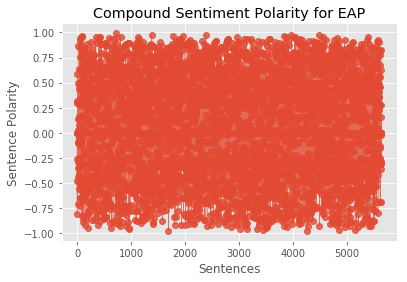

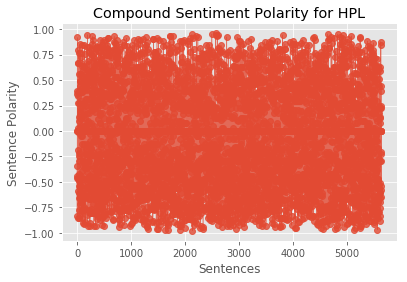

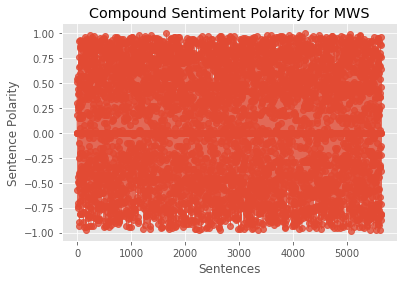

In [27]:
# create empty dictionaries to contain avg sentiment values for all sentences by authors
avg_compound = {}
avg_pos = {}
avg_neu = {}
avg_neg = {}

# create empty dictionaries to contain std of sentiments for all sentences by authors
std_compound = {}
std_pos = {}
std_neu = {}
std_neg = {}

for name, group in byAuthor:
    compound = [d['compound'] for d in sentimentByAuthor[name]]
    pos = [d['pos'] for d in sentimentByAuthor[name]]
    neu = [d['neu'] for d in sentimentByAuthor[name]]
    neg = [d['neg'] for d in sentimentByAuthor[name]]
    
    avg_compound[name] = sum(compound) / len(sentimentByAuthor[name])
    avg_pos[name] = sum(pos) / len(sentimentByAuthor[name])
    avg_neu[name] = sum(neu) / len(sentimentByAuthor[name])
    avg_neg[name] = sum(neg) / len(sentimentByAuthor[name])
    
    std_compound[name] = np.std(compound, axis = None)
    std_pos[name] = np.std(pos, axis = None)
    std_neu[name] = np.std(neu, axis = None)
    std_neg[name] = np.std(neg, axis = None)
    
    # plot compound sentiment analysis for each author
    #plt.figure(figsize = (10,10))
    plt.title('Compound Sentiment Polarity for ' + name)
    plt.xlabel('Sentences')
    plt.ylabel('Sentence Polarity')
    plt.plot(np.arange(0, len(compound)), compound,  marker="o", linewidth=0.5,
         alpha=0.8)
    plt.show()

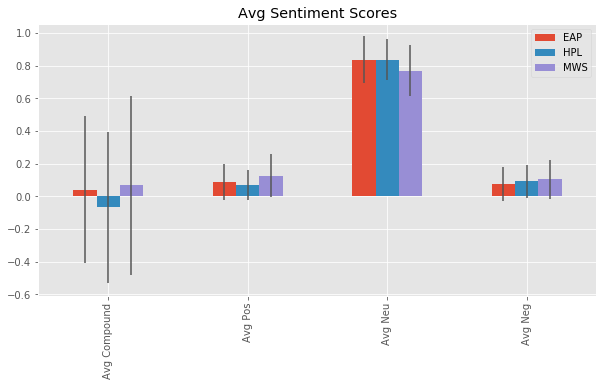

,EAP,HPL,MWS
Avg Compound,0.040366,-0.067891,0.067516
Avg Pos,0.086742,0.070504,0.126776
Avg Neu,0.838065,0.837864,0.770086
Avg Neg,0.075194,0.091637,0.103139


In [28]:
# plot bar graph of avg sentiment scores with error bars for each author 


avg_sentiments = {'EAP':[avg_compound['EAP'], avg_pos['EAP'], avg_neu['EAP'] ,avg_neg['EAP']],
                  'HPL': [avg_compound['HPL'], avg_pos['HPL'], avg_neu['HPL'] ,avg_neg['HPL']],
                  'MWS': [avg_compound['MWS'], avg_pos['MWS'], avg_neu['MWS'] ,avg_neg['MWS']]}
std_sentiments = {'EAP':[std_compound['EAP'], std_pos['EAP'], std_neu['EAP'] ,std_neg['EAP']],
                  'HPL': [std_compound['HPL'], std_pos['HPL'], std_neu['HPL'] ,std_neg['HPL']],
                  'MWS': [std_compound['MWS'], std_pos['MWS'], std_neu['MWS'] ,std_neg['MWS']]}
indexNames = ['Avg Compound', 'Avg Pos', 'Avg Neu', 'Avg Neg']
avg_sentimentsdf = pd.DataFrame(avg_sentiments, index = indexNames) 
std_sentimentsdf = pd.DataFrame(std_sentiments, index = indexNames)
    
#plt.figure(figsize = (10,10))
ax = avg_sentimentsdf.plot(kind = 'bar', title = 'Avg Sentiment Scores', 
                      legend=True , yerr= std_sentimentsdf, figsize=(10, 5))
plt.savefig('plots/sentiment_scores.png', dpi = 300)
plt.show()

avg_sentimentsdf

## ANOVA analyses

### Sentence length

In [29]:
grps = pd.unique(texts_len.author.values)
sent_len = {grp:texts_len['sentence_len'][texts_len.author == grp] for grp in grps}

F, p = stats.f_oneway(sent_len['EAP'], sent_len['HPL'], sent_len['MWS'])

print(F)
print(p)

23.7559433033
4.98194069992e-11


### Word variety

In [30]:
vocab = {grp:texts_len['vocab'][texts_len.author == grp] for grp in grps}

F, p = stats.f_oneway(vocab['EAP'], vocab['HPL'], vocab['MWS'])

print(F)
print(p)

50.4527679244
1.42491162316e-22


### Word length

In [31]:
# create empty dictionary to populate with word lengths by author 
wordlengthByAuthor_all = {}

# for each author...
for key, value in token_dict.items():
    
    # characterizing words by different lengths
    word_len = [len(w) for w in value]
    wordlengthByAuthor_all[key] = word_len
    
F, p = stats.f_oneway(wordlengthByAuthor_all['EAP'], wordlengthByAuthor_all['HPL'], wordlengthByAuthor_all['MWS'])

print(F)
print(p)

224.443485749
3.69657543387e-98
